In [1]:
from youtube_transcript_api import YouTubeTranscriptApi
from langchain.tools import tool
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Markdown
from langgraph.types import interrupt
from langgraph.types import Command
import os

# Initialize memory saver
memory = MemorySaver()

# Load environment variables
load_dotenv()

# Initialize OpenAI and Groq chatbots
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

# Initialize Groq chatbot
llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")

def get_youtube_transcript(video_url):
    try:
        # Extract Video ID from URL
        video_id = video_url.split("v=")[-1].split("&")[0]

        # Fetch transcript
        transcript = YouTubeTranscriptApi.get_transcript(video_id)

        # Convert transcript list to text
        transcript_text = "\n".join([entry["text"] for entry in transcript])

        return transcript_text

    except Exception as e:
        return f"Error: {str(e)}"


In [2]:
# Graph state
class State(TypedDict):
    video_url: str
    transcript: str
    blog: str
    review: str
    human_feedback: str

def transcript_generation(state: State) -> State:
    # Fetch transcript
    state["transcript"] = get_youtube_transcript(state["video_url"])
    return state
    
def blog_generation(state: State) -> State:
    if state.get("human_feedback"):
        state["blog"] = llm.invoke(
            f"Generate a blog post for the transcript below:\n{state['transcript']}\n"
            f"Consider the following feedback: {state['human_feedback']}"
        )
    else:
        state["blog"] = llm.invoke(
            f"Generate a blog post for the transcript below:\n{state['transcript']}"
        )
    return state

def review_generation(state: State) -> State:
    # Generate review
    state["review"] = llm.invoke(f"Generate review for the blog post below \n {state['blog']}")
    return state

def human_feedback1(state: State) -> State:
    print("Awaiting human feedback...")
    feedback = interrupt("Please provide your feedback:")
    return {"human_feedback": feedback}
    
def should_continue(state: State) -> str:
    if state.get("human_feedback"):
        return "blogger"
    return END

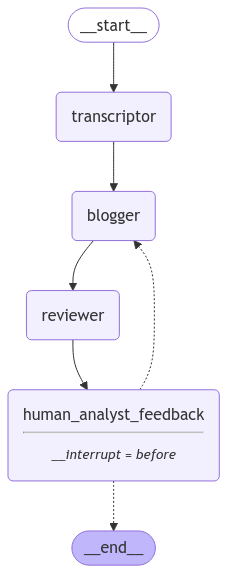

In [3]:
builder = StateGraph(State)
#Nodes
builder.add_node("transcriptor", transcript_generation)
builder.add_node("blogger", blog_generation)
builder.add_node("reviewer", review_generation)
builder.add_node("human_analyst_feedback", human_feedback1)

#Edges
builder.add_edge(START, "transcriptor")
builder.add_edge("transcriptor", "blogger")
builder.add_edge("blogger", "reviewer")
builder.add_edge("reviewer", "human_analyst_feedback")
builder.add_conditional_edges("human_analyst_feedback", should_continue, ["blogger", END])


workflow = builder.compile(interrupt_before=['human_analyst_feedback'], checkpointer=memory)
# Show the workflow
display(Image(workflow.get_graph().draw_mermaid_png()))


In [4]:
thread = {"configurable": {"thread_id": "1"}}
# Run the graph until the first interruption
for event in workflow.stream({"video_url": "https://www.youtube.com/watch?v=cy6EAp4iNN4"}, thread, stream_mode="values"):
    print(event)
    blog = event.get("blog", None)
    review = event.get("review", None)
    if blog is not None and review is not None:
        display(Markdown(blog.content))
        display(Markdown(review.content))
        break
    

{'video_url': 'https://www.youtube.com/watch?v=cy6EAp4iNN4'}
{'video_url': 'https://www.youtube.com/watch?v=cy6EAp4iNN4', 'transcript': "AI models are powerful tools but in\norder to use them properly and securely\nyou need to control them using an API so\nin today's video I'm going to show you\nhow to write a very simple python API to\ncontrol access to an llm or an AI model\nnow first I want to explain why you\nactually need to do this you understand\nthe security and the importance of\nsetting this up now let's say that you\nwant to use an llm something like chat\nGPT or something like deep seek right if\nthat's the case what you're probably\ngoing to do is you're either going to\nattempt to run this locally or you're\ngoing to use the cloud provider so\nyou're going to go to deepseeker open\naai you're going to generate an API key\nand then you're going to take that API\nkey and that's what you send anytime you\nwant to make a request or use the llm\nnow this is great and it works 

### Controlling Access to AI Models with a Secure Python API

AI models have revolutionized the way we interact with data and automate tasks, but with great power comes great responsibility. Ensuring these models are used securely and responsibly is crucial, especially when it comes to managing costs and user access. In this blog post, I’ll guide you through creating a secure Python API to control access to an AI model, using a local language model (LLM) via a tool called AMA. This method allows you to manage who can access your AI model, ensuring your resources aren’t abused.

#### Why Control Access?

Access control is paramount when integrating AI models into production environments. For instance, using a model like OpenAI’s GPT or DeepSeek’s DeepSeeker directly from a front-end application introduces significant security risks. If you embed an API key directly into your front-end code, anyone can potentially access and misuse it, leading to unauthorized usage and significant financial costs.

To mitigate this, you should control the model's access from a backend server, where you can manage requests, user permissions, and resource costs.

#### Setting Up the Environment

Before diving into the code, you need to have your environment ready to run a local LLM. Using AMA, a tool for running language models locally, you can achieve this without the need for cloud-based resources. You’ll need to install AMA and pull a model to run locally.

1. **Install AMA**: Follow the instructions on the AMA GitHub or documentation to install it.
2. **Pull a Model**: Use the command `ama pull mistral` to download and set up a model like Mistral.

#### Building the API

To build the API, you'll use FastAPI, a modern, fast (high-performance) web framework for building APIs with Python 3.7+ based on standard Python type hints.

1. **Setup Dependencies**: Create a `requirements.txt` file with the dependencies (`fastapi`, `uvicorn`, `olama`, `python-dotenv`, `requests`).
2. **Install Dependencies**: Use `pip install -r requirements.txt` to install the necessary libraries.
3. **Create the API Script**: Create a `main.py` file where the magic happens.

```python
from fastapi import FastAPI, Depends, HTTPException
from olama import chat
import os
from dotenv import load_dotenv
import requests

app = FastAPI()

load_dotenv()
API_KEY = os.getenv('API_KEY')
API_KEY_CREDITS = {API_KEY: 5}  # Setting up credits for the API key

def verify_api_key(x_api_key: str = Depends()):
    credits = API_KEY_CREDITS.get(x_api_key, 0)
    if credits <= 0:
        raise HTTPException(status_code=401, detail="Invalid API key or no credits")
    API_KEY_CREDITS[x_api_key] -= 1
    return x_api_key

@app.post("/generate")
def generate(prompt: str, x_api_key: str = Depends(verify_api_key)):
    response = chat(model="mistral", messages=[{"role": "user", "content": prompt}])
    return {"response": response}

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
```

#### Testing the API

To test the API, you can use a tool like Postman or write a simple Python script.

1. **Using Postman**: Set up a POST request to `http://localhost:8000/generate` with the header `X-API-KEY` and the value of your secret key.

2. **Python Script**: Here’s a simple script to test your API:

```python
import requests
from dotenv import load_dotenv
import os

load_dotenv()

API_URL = "http://localhost:8000/generate"
API_KEY = os.getenv('API_KEY')
PROMPT = "What is the meaning of life?"

response = requests.post(API_URL, json={"prompt": PROMPT}, headers={"X-API-KEY": API_KEY})
print(response.json())
```

#### Conclusion

By setting up a secure API to control access to your AI model, you ensure that only authorized users can interact with your model, and you can manage their usage to avoid unnecessary costs. This setup can be further extended by integrating user authentication, user roles, and more advanced credit systems to handle larger-scale applications.

Remember, while this example is basic, the principles can be extended to create more sophisticated systems, depending on your application needs. Safety and security are paramount, and by managing access through your own backend server, you take a significant step in securing your AI model usage.

### Review of "Controlling Access to AI Models with a Secure Python API"

The blog post titled "Controlling Access to AI Models with a Secure Python API" is a well-crafted guide that addresses a critical aspect of AI model deployment: security and access control. The post is structured in a logical manner, providing a clear breakdown of the need for access control, the setup process, and an implementation example using Python and FastAPI.

#### Strengths:

1. **Comprehensive Explanation of Importance:**
   - The post begins with a thorough explanation of why controlling access to AI models is crucial, particularly in production environments. It highlights the security risks associated with direct API key embedding in front-end applications and the potential for misuse, which is an important point for developers to consider.

2. **Practical and Detailed Instructions:**
   - The instructions for setting up the environment with AMA (a tool for running language models locally) are detailed and straightforward, providing a clear path for readers to follow along.
   - The API building section is particularly robust, with step-by-step guidance on how to set up the dependencies, create the API script, and even handle user authentication and credit management through API keys.

3. **Code Examples:**
   - The inclusion of code snippets not only enhances the practicality of the post but also makes it easier for readers to understand and implement the solution. The FastAPI-based API script is well-commented and provides a good starting point for implementing a secure API for AI models.

4. **Testing the API:**
   - The post includes methods for testing the API using both Postman and a Python script, which is useful for readers who want to verify the functionality of their setup. This approach caters to a broader audience, from those preferring GUI-based testing to those who prefer scripting.

#### Areas for Improvement:

1. **Advanced Security Practices:**
   - While the post covers the basics of API key verification and credit management, it could delve deeper into advanced security practices such as encryption, rate limiting, and more refined authentication mechanisms. This would provide a more comprehensive security framework for handling AI models.

2. **Scalability and Performance Considerations:**
   - The post could benefit from a section discussing how to scale the API and handle performance issues that might arise with higher user counts. This could include strategies for load balancing, caching, and optimizing API responses, which are essential for production environments.

3. **Deployment and Monitoring:**
   - Although the post focuses on building the API, a brief section on how to deploy such an API in a production environment (e.g., Docker, Kubernetes) and how to monitor its performance and security could add significant value.

Overall, "Controlling Access to AI Models with a Secure Python API" is a valuable resource for developers looking to secure their AI models and manage user access responsibly. The post effectively balances theory with practical implementation, making it an excellent guide for both beginners and experienced developers in the field of AI and API development.

In [5]:
user_feedback = input("Please provide your feedback:")
if user_feedback:
    workflow.invoke(Command(resume=user_feedback), thread)
else:
    workflow.invoke(Command(resume=""), thread)

Awaiting human feedback...


In [10]:
state.values

{'video_url': 'https://www.youtube.com/watch?v=cy6EAp4iNN4',
 'transcript': "AI models are powerful tools but in\norder to use them properly and securely\nyou need to control them using an API so\nin today's video I'm going to show you\nhow to write a very simple python API to\ncontrol access to an llm or an AI model\nnow first I want to explain why you\nactually need to do this you understand\nthe security and the importance of\nsetting this up now let's say that you\nwant to use an llm something like chat\nGPT or something like deep seek right if\nthat's the case what you're probably\ngoing to do is you're either going to\nattempt to run this locally or you're\ngoing to use the cloud provider so\nyou're going to go to deepseeker open\naai you're going to generate an API key\nand then you're going to take that API\nkey and that's what you send anytime you\nwant to make a request or use the llm\nnow this is great and it works well if\nyou're doing this locally but in a\nproduction envi

In [16]:
from IPython.display import Markdown, display

# Run the workflow
thread = {"configurable": {"thread_id": "1"}}
final_state = workflow.invoke({"video_url": "https://www.youtube.com/watch?v=cy6EAp4iNN4"}, thread)

# Retrieve the final blog content
#final_blog = final_state.get("blog")

# Display the final blog content if it exists
if final_blog:
    display(Markdown(final_state['blog'].content))
else:
    print("No blog content generated.")

### Securing Access to AI Models with a Simple Python API: A Creative Guide

AI models are incredibly powerful but, just like any powerful tool, they come with their own set of responsibilities—chief among them, ensuring that they're used securely and efficiently. In this blog post, we'll dive into how to create a simple Python API to control access to your AI model, whether it's a local model or one hosted on a cloud service. Let’s embark on this adventure, making sure we wield our AI models with care and precision.

#### Why Secure Your AI Model?

Before diving into the code, let’s understand why securing your AI model is essential. Imagine your AI model as a magical portal to the world of intelligent responses. Without proper control, anyone with access can tap into this portal, potentially draining your resources or even compromising its integrity. By controlling, we mean ensuring only authorized users have access, and each use is tracked, much like a magical token that can only be used a certain number of times.

#### Building the Foundation

To get started, you’ll need to set up your environment. For this guide, we’ll use `FastAPI`, a modern, fast (high-performance) web framework for building APIs with Python 3.7+ based on standard Python type hints. Our AI model will be a local model, and we’ll use `olama`, a tool that lets you run models on your own machine. This is a free, open-source treasure that you can download and install based on your hardware capabilities.

#### Crafting the API

1. **Setting Up Your Environment:**

   First, create a `requirements.txt` file with all the necessary dependencies. Our dependencies include `FastAPI`, `uvicorn` for running the server, and `olama` for interfacing with the local AI model. Install these by running `pip install -r requirements.txt` in your terminal.

2. **Creating the API Structure:**

   In your Python file, which we’ll name `main.py`, start by importing the necessary modules and setting up the FastAPI application.

   ```python
   from fastapi import FastAPI, HTTPException
   import olama
   import os
   from dotenv import load_dotenv

   # Load environment variables
   load_dotenv()
   ```

3. **Securing the API:**

   The heart of this project is ensuring that only those with the right access (think of it as a magical key) can use the model. For this, we’ll simulate an API key system.

   ```python
   # Define the API key
   API_KEYS = set(os.getenv('API_KEYS').split(','))

   def verify_api_key(x_api_key: str = Header(...)):
       """
       Verify the API key.
       If the key is valid, return it. If not, raise an exception.
       """
       if x_api_key not in API_KEYS:
           raise HTTPException(status_code=401, detail="Invalid API Key")
       return x_api_key
   ```

   In your `main.py`, specify an endpoint, `/generate`, that requires a POST request and an API key.

   ```python
   @app.post("/generate")
   def generate(prompt: str, x_api_key: str = Depends(verify_api_key)):
       # Check credits and generate response
       return olama.chat(model="mistol", messages=[{"role": "user", "content": prompt}])
   ```

4. **Testing the API:**

   Once your API is up and running, test it using Postman (a magical wand for HTTP requests). Yes, it’s that cool). You’ll need to specify the URL (`http://localhost:8000/generate`), send a POST request, and include the API key as a header. If all goes well, you’ll see the AI model’s response, and if your API key runs out, it’ll politely refuse to play.

#### Finishing Touches

Adding an authentication layer to your API is like adding a guardian dragon to protect your digital treasure. Not only does it keep the intruders out, but it also allows you to control how your AI is used, ensuring it’s a valuable and secure resource.

#### Wrapping Up

By securing your AI model with a simple Python API, you’re not just protecting your resources; you’re taking a step towards building a more secure and controlled environment for your AI applications. Whether you’re a beginner or a seasoned developer, the principles here can be adapted and expanded upon to suit more complex needs.

If you enjoyed this journey into securing AI models with Python, be sure to follow more tutorials on this blog for more magical coding adventures!

--- 

This creative twist on your transcript adds a bit of fantasy and narrative to the technical process, making it more engaging and easier to understand.

In [13]:
final_state = workflow.invoke({"video_url": "https://www.youtube.com/watch?v=cy6EAp4iNN4"}, thread)

In [15]:
final_state['blog'].content

"### Crafting Secure Access to AI Models with Python APIs\n\nIn the realm of artificial intelligence, where large language models (LLMs) like ChatGPT and DeepSeek are becoming increasingly powerful, it's crucial to ensure that these tools are used both effectively and securely. Today, we delve into how to create a simple yet robust Python API that controls access to an LLM, ensuring that it's not only functional but also secure from unauthorized use.\n\n#### Why Secure API Control is Essential\n\nImagine you're leveraging an LLM to power a feature in your application. Whether it's running locally on your machine or through a cloud provider like OpenAI, the API key for accessing these services can be a juicy target for misuse, especially if it's exposed in your frontend code. This isn't just about safeguarding against external threats; it's also about ensuring that your application remains financially and resource-efficient.\n\n#### Setting Up the Environment\n\nBefore diving into the c